In [105]:
# import libraries

import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [69]:
# set display settings

warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

In [70]:
# specify columns, datatypes, and load full consolidated sdss dataset

# load column names from file into a list
sdss_headers = pd.read_csv('../data/processed/sdss_full.csv.gz', compression='gzip', header=0, index_col=0, nrows=0).columns.tolist()

# specify groups of primary columns
object_identifiers = ['dr8objid']
galaxy_identifiers = ['gz2_filenumber']
object_locations = ['ra', 'dec']
object_class_labels = ['sdss_clean_class_name']
star_class_labels = ['stellar_subclass_MK']
galaxy_class_labels =['gz2_subclass_hubble']
galaxy_binary_labels = [label for label in sdss_headers if 'flag' in label]
object_features = ['redshift_final', 'sum_p', 'u-r_p', 'g-i_p', 'r-z_p']  # note that for most cases, redshift_final should be transformed to redshift_log
star_features = ['elodie_color_index', 'elodie_temperature', 'elodie_metallicity']
# consider adding galaxy features:  ratio of petro_radius to petro_brightness

# create a datatype dictionary for object_identifiers
col_dtypes = {col: 'string' for col in object_identifiers + galaxy_identifiers}

# load full consolidated sdss dataset
sdss_primary = pd.read_csv('../data/processed/sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)

/tmp/ipykernel_17380/3682879233.py:22: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  sdss_primary = pd.read_csv('../data/processed/sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)


In [4]:
# inspect the imported data
 
 # display some data
display(sdss_primary.head(3))
display(sdss_primary.tail(3))
display(sdss_primary.sample(10))
 
# inspect dataframe
print(sdss_primary.shape)
print(sdss_primary.info())

,dr8objid,gz2_filenumber,ra,dec,sdss_clean_class_name,stellar_subclass_MK,gz2_subclass_hubble,gz1_flag_spiral,gz1_flag_elliptical,gz1_flag_uncertain,gz2_flag_smooth,gz2_flag_features_or_disk,gz2_flag_star_or_artifact,gz2_flag_edgeon_yes,gz2_flag_edgeon_no,gz2_flag_bar_yes,gz2_flag_bar_no,gz2_flag_spiral_yes,gz2_flag_spiral_no,gz2_flag_bulge_none1,gz2_flag_bulge_small,gz2_flag_bulge_medium,gz2_flag_bulge_large,gz2_flag_odd_yes,gz2_flag_odd_no,gz2_flag_round_circular,gz2_flag_round_medium,gz2_flag_round_cigar,gz2_flag_feature_ring,gz2_flag_feature_lens_or_arc,gz2_flag_feature_disturbed,gz2_flag_feature_irregular,gz2_flag_feature_other,gz2_flag_feature_merger,gz2_flag_feature_dust_lane,gz2_flag_bulge_round,gz2_flag_bulge_boxy,gz2_flag_bulge_none2,gz2_flag_arms_tight,gz2_flag_arms_medium,gz2_flag_arms_loose,gz2_flag_arms_1,gz2_flag_arms_2,gz2_flag_arms_3,gz2_flag_arms_4,gz2_flag_arms_many,gz2_flag_arms_unsure,redshift_final,sum_p,u-r_p,g-i_p,r-z_p,elodie_color_index,elodie_temperature,elodie_metallicity
0,1237651252584448100,192933,236.355530,54.820911,galaxy,unclassified,SBc,True,False,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,0.080127,85.88830,2.09786,1.09673,0.63014,NaN,NaN,NaN
1,1237651252584448112,<NA>,236.342000,54.802830,galaxy,unclassified,unclassified,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.193371,88.50900,2.39652,1.32288,0.71409,NaN,NaN,NaN
2,1237651252584251555,32264,235.891464,55.133472,galaxy,unclassified,SBc,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.040399,77.52239,2.37586,1.12715,0.67207,NaN,NaN,NaN


,dr8objid,gz2_filenumber,ra,dec,sdss_clean_class_name,stellar_subclass_MK,gz2_subclass_hubble,gz1_flag_spiral,gz1_flag_elliptical,gz1_flag_uncertain,gz2_flag_smooth,gz2_flag_features_or_disk,gz2_flag_star_or_artifact,gz2_flag_edgeon_yes,gz2_flag_edgeon_no,gz2_flag_bar_yes,gz2_flag_bar_no,gz2_flag_spiral_yes,gz2_flag_spiral_no,gz2_flag_bulge_none1,gz2_flag_bulge_small,gz2_flag_bulge_medium,gz2_flag_bulge_large,gz2_flag_odd_yes,gz2_flag_odd_no,gz2_flag_round_circular,gz2_flag_round_medium,gz2_flag_round_cigar,gz2_flag_feature_ring,gz2_flag_feature_lens_or_arc,gz2_flag_feature_disturbed,gz2_flag_feature_irregular,gz2_flag_feature_other,gz2_flag_feature_merger,gz2_flag_feature_dust_lane,gz2_flag_bulge_round,gz2_flag_bulge_boxy,gz2_flag_bulge_none2,gz2_flag_arms_tight,gz2_flag_arms_medium,gz2_flag_arms_loose,gz2_flag_arms_1,gz2_flag_arms_2,gz2_flag_arms_3,gz2_flag_arms_4,gz2_flag_arms_many,gz2_flag_arms_unsure,redshift_final,sum_p,u-r_p,g-i_p,r-z_p,elodie_color_index,elodie_temperature,elodie_metallicity
1089270,1237658613593866399,<NA>,176.96573,50.196095,quasar,unclassified,unclassified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.325296,102.50690,0.67220,0.42938,0.26503,0.0,0.0,0.0
1089271,1237658613593997533,<NA>,177.50007,50.211641,quasar,unclassified,unclassified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.076416,108.06205,0.25209,0.30271,0.49985,0.0,0.0,0.0
1089272,1237658613594063058,<NA>,177.79678,50.375821,quasar,unclassified,unclassified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.856644,107.44989,0.43338,0.38276,0.49819,0.0,0.0,0.0


,dr8objid,gz2_filenumber,ra,dec,sdss_clean_class_name,stellar_subclass_MK,gz2_subclass_hubble,gz1_flag_spiral,gz1_flag_elliptical,gz1_flag_uncertain,gz2_flag_smooth,gz2_flag_features_or_disk,gz2_flag_star_or_artifact,gz2_flag_edgeon_yes,gz2_flag_edgeon_no,gz2_flag_bar_yes,gz2_flag_bar_no,gz2_flag_spiral_yes,gz2_flag_spiral_no,gz2_flag_bulge_none1,gz2_flag_bulge_small,gz2_flag_bulge_medium,gz2_flag_bulge_large,gz2_flag_odd_yes,gz2_flag_odd_no,gz2_flag_round_circular,gz2_flag_round_medium,gz2_flag_round_cigar,gz2_flag_feature_ring,gz2_flag_feature_lens_or_arc,gz2_flag_feature_disturbed,gz2_flag_feature_irregular,gz2_flag_feature_other,gz2_flag_feature_merger,gz2_flag_feature_dust_lane,gz2_flag_bulge_round,gz2_flag_bulge_boxy,gz2_flag_bulge_none2,gz2_flag_arms_tight,gz2_flag_arms_medium,gz2_flag_arms_loose,gz2_flag_arms_1,gz2_flag_arms_2,gz2_flag_arms_3,gz2_flag_arms_4,gz2_flag_arms_many,gz2_flag_arms_unsure,redshift_final,sum_p,u-r_p,g-i_p,r-z_p,elodie_color_index,elodie_temperature,elodie_metallicity
352688,1237668297133981948,175109,193.807297,18.989227,galaxy,unclassified,Ec,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,0.065567,81.88586,2.56107,1.23154,0.75265,NaN,NaN,NaN
203858,1237661972264124531,222526,196.060150,7.903835,galaxy,unclassified,Ee,False,True,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.044374,76.79662,2.89282,1.34371,0.72500,NaN,NaN,NaN
757530,1237666275813950182,<NA>,24.942370,24.302324,star,unclassified,unclassified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000125,104.94286,3.10769,1.77528,0.81979,0.429,6180.0,-0.41
690891,1237659329239974429,<NA>,242.941980,41.492283,quasar,unclassified,unclassified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.300236,102.10570,0.83039,0.20058,0.61135,0.000,0.0,0.00
58470,1237655373573259572,<NA>,247.828100,40.486390,galaxy,unclassified,unclassified,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.182398,89.80405,3.07188,1.63689,0.78406,NaN,NaN,NaN
824296,1237672793959956709,<NA>,0.954823,-6.349631,star,M,unclassified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000158,100.52762,5.10043,2.37534,1.41633,1.502,3717.0,-0.20
486535,1237668611197763830,184455,244.930939,50.155674,galaxy,unclassified,Er,True,False,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.056981,84.86654,2.05716,1.07173,0.72804,NaN,NaN,NaN
50832,1237655107308814484,<NA>,204.866000,57.677220,galaxy,unclassified,unclassified,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.124277,89.38275,3.14117,1.46792,0.76186,NaN,NaN,NaN
605355,1237657632727957854,<NA>,151.082580,51.740758,quasar,unclassified,unclassified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.311950,106.38426,0.27912,0.62110,0.27830,0.000,0.0,0.00
861745,1237662226204196868,<NA>,153.585920,36.620724,quasar,unclassified,unc

(1089273, 55)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089273 entries, 0 to 1089272
Data columns (total 55 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   dr8objid                      1089273 non-null  string 
 1   gz2_filenumber                222372 non-null   string 
 2   ra                            1089273 non-null  float64
 3   dec                           1089273 non-null  float64
 4   sdss_clean_class_name         1089273 non-null  object 
 5   stellar_subclass_MK           1089273 non-null  object 
 6   gz2_subclass_hubble           1089273 non-null  object 
 7   gz1_flag_spiral               531099 non-null   object 
 8   gz1_flag_elliptical           531099 non-null   object 
 9   gz1_flag_uncertain            531099 non-null   object 
 10  gz2_flag_smooth               222372 non-null   object 
 11  gz2_flag_features_or_disk     222372 non-null   object 
 12  gz2_flag_star_


---------- sdss_clean_class_name : None ----------
The number of rows with classified values is: 1089273
The number of unique labels is: 3


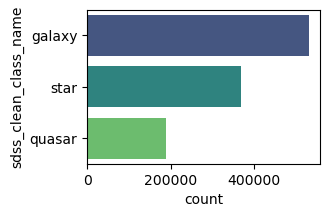


---------- gz2_subclass_hubble : galaxy ----------
The number of rows with classified values is: 222372
The number of unique labels is: 12


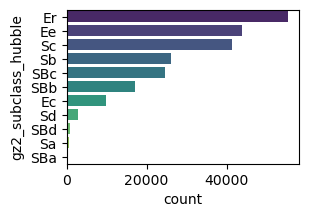


---------- stellar_subclass_MK : star ----------
The number of rows with classified values is: 117478
The number of unique labels is: 9


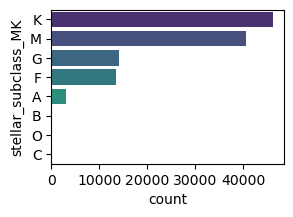

In [5]:
# investigate superclasses & simplified subclasses (categorical labels)

# create a helper function for investigating and plotting a subset from a column w/ categorical data
def investigate_clean_classes(df, column, filter=None):
    data = df[column]
    if filter:
        data = df[df['sdss_clean_class_name'] == filter][column]
    unclassified_count = data.isna().sum() + (data == 'unclassified').sum() + (data == 'unkonwn').sum()
    print(f"\n---------- {column} : {filter} ----------")
    print(f"The number of rows with classified values is: {len(data) - unclassified_count}")
    print(f"The number of unique labels is: {len(df[column].unique())}")
    data2 = data[data != 'unclassified']
    data2 = data2[data2 != 'unknown']
    plt.figure(figsize=(3, 2))
    sns.countplot(y=data2, order=data2.value_counts().index[:15], palette='viridis')
    #plt.suptitle(f"{column = }")
    #plt.tight_layout()
    plt.show()

investigate_clean_classes(sdss_primary, 'sdss_clean_class_name')
investigate_clean_classes(sdss_primary, 'gz2_subclass_hubble', 'galaxy')
investigate_clean_classes(sdss_primary, 'stellar_subclass_MK', 'star')

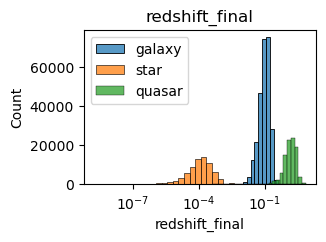

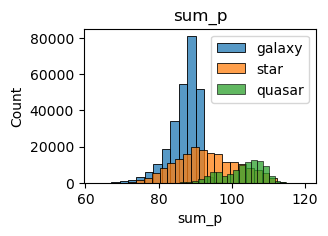

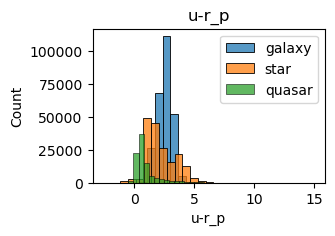

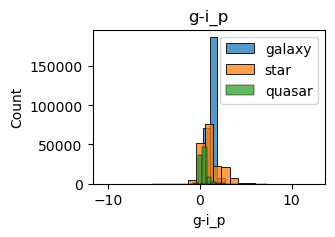

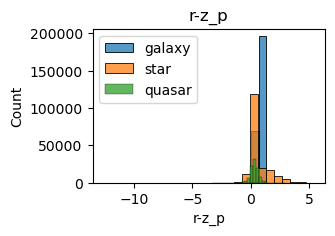

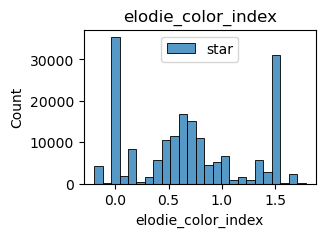

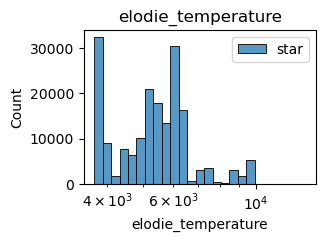

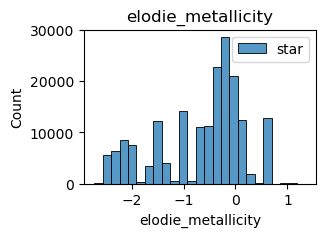

In [100]:
# investigate histograms of feature columns, color-shaded by superclass

# generate a subset dataframe
df = sdss_primary[['sdss_clean_class_name'] + object_features + star_features]
df = df.sample(frac=0.5)

# define classes
classes = sdss_primary['sdss_clean_class_name'].unique()

# set a color palette with distinct colors for each category
colors = sns.color_palette('bright', n_colors=len(df['sdss_clean_class_name'].unique()))

# iterate over columns and create separate plots
for col in object_features + star_features:
    plt.figure(figsize=(3, 2))
    plt.xscale('linear')
    log_choice = False
    denom = df[col].min()
    if denom == 0:
        denom = 0.001
    if abs(df[col].max() / denom) > 50:
        df[col] = df[col].replace(0, 0.001)
        log_choice = True
        plt.xscale('symlog')  
    for class_label, color in zip(classes, colors):
        if 'elodie' in col:
            if class_label == 'star':
                sns.histplot(df[df['sdss_clean_class_name'] == class_label][col], bins=25, label=class_label, log_scale=log_choice)
        else:
            sns.histplot(df[df['sdss_clean_class_name'] == class_label][col], bins=25, label=class_label, log_scale=log_choice)
    plt.title(col)
    plt.legend()
    plt.show()

In [155]:
# feature engineering - create a new feature based on the log-transform of redshift_final

# create the new feature
sdss_primary['redshift_log'] = np.log(sdss_primary['redshift_final'] - 2 * sdss_primary['redshift_final'].min())

# re-specify groups of object feature columns
object_features = ['redshift_log', 'sum_p', 'u-r_p', 'g-i_p', 'r-z_p']

In [161]:
# specify and transform the data

# specify the clustering data
#X = np.array(sdss_primary[object_features].values)
X = np.array(sdss_primary[['redshift_log']].values)

# transform he data - apply z-standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# display some data
print(X)

[[ 0.0664356 ]
 [ 0.54724632]
 [-0.26737696]
 ...
 [ 1.68261845]
 [ 1.55749274]
 [ 1.88598538]]


In [162]:
# define a helper function to generate a k-means clustering model

# define the model's functional form
def fit_kmeans(X, n_clusters):
    model = KMeans(
        n_clusters = n_clusters,
        init = 'k-means++',
        n_init = 10,
        max_iter = 300,
        tol = 1e-04,
    )
    model.fit(X)
    return model

In [163]:
# create a k-means model with 3 clusters (same as number of known superclasses)

# specify the number of clusters
# NOTE: clusters will be assigned numbers 0, 1, 2
n_clusters = len(sdss_primary['sdss_clean_class_name'].unique())

# generate the model
model = fit_kmeans(X, n_clusters)

# get predictions & add them to the dataframe
sdss_primary['superclass_k-means_cluster'] = model.predict(X)

,sdss_clean_class_name,superclass_k-means_cluster
531239,quasar,1
736385,quasar,1
645192,star,0
1018498,quasar,1
436987,galaxy,2
612535,star,0
821089,star,0
22739,galaxy,2
399370,galaxy,2
1003184,star,0


---- galaxy ----
	% assigned to cluster 0: 0.03197332324105299
	% assigned to cluster 1: 0.00022782946305679354
	% assigned to cluster 2: 0.9677988472958903
---- star ----
	% assigned to cluster 0: 1.0
	% assigned to cluster 1: 0.0
	% assigned to cluster 2: 0.0
---- quasar ----
	% assigned to cluster 0: 0.0002479517601937189
	% assigned to cluster 1: 0.9631132189941599
	% assigned to cluster 2: 0.036638829245646334


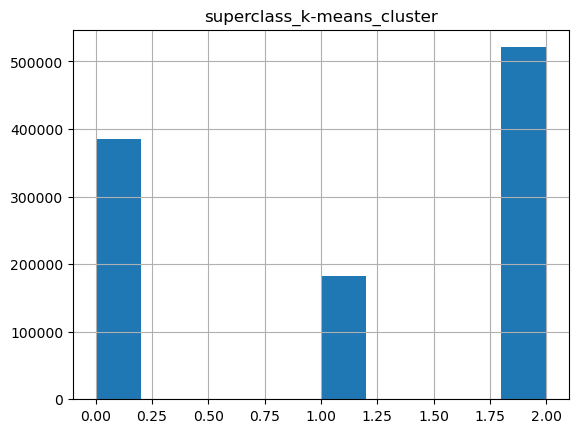

In [164]:
# visualize results of the model

# display some data
display(sdss_primary[['sdss_clean_class_name', 'superclass_k-means_cluster']].sample(10))

# create a helper function to evaluate accuracy
def evaluate_cluster_accuracy(n_clusters):
    for label in sdss_primary['sdss_clean_class_name'].unique().tolist():
        print(f"---- {label} ----")
        num_objects = len(sdss_primary[sdss_primary['sdss_clean_class_name'] == label])
        for n in range(n_clusters):
            num_matches = len(sdss_primary[(sdss_primary['sdss_clean_class_name'] == label) & (sdss_primary['superclass_k-means_cluster'] == n)])
            print(f"\t% assigned to cluster {n}: {num_matches / num_objects}")
        
# inspect clustering accuracy
evaluate_cluster_accuracy(3)

# print histogram of cluster counts
sdss_primary.hist(column='superclass_k-means_cluster')
plt.show()

In [ ]:
# CONCLUSION: THE ACCURACY IS MUCH HIGHER IF I ONLY INCLUDE REDSHIFT_LOG, AS OPPOSED TO INCLUDING REDSHIFT_LOG + ALL THE PHOTOMETRIC FEATURES
# NEXT STEPS:  1) TRY FINE-TUNING THE MODEL HYPERPARAMETERS, 2) TRY TO REGULARIZE THE MODEL;  3) IF ALL ELSE FAILS, I CAN DO PCA PRIOR TO THE MODELING TO DIMINISH THE IMPORTANCE OF THE PHOTOMETRIC VARIABLES
# FINAL STEPS: MAKE PRETTY PLOTS AND TABLES TO SUMMARIZE